In [ ]:
!pip install yfinance

In [ ]:
import pandas as pd
import numpy as np

options_data = pd.read_csv("/content/options-JAN2023-MAY2025 (1)")
display(options_data)

In [ ]:
import yfinance as yf
import pandas as pd

ticker = 'RELIANCE.NS'
stock_data = yf.download(ticker, start='2023-01-01', end='2025-05-29')
stock_data = stock_data[['Open', 'High', 'Low', 'Close', 'Volume']]
# stock_data.dropna(inplace=True)


In [ ]:
display(stock_data)

In [ ]:
stock_data = stock_data.reset_index()


In [ ]:
stock_data.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in stock_data.columns]


In [ ]:
print(stock_data.columns)

Index(['Date_', 'Open_RELIANCE.NS', 'High_RELIANCE.NS', 'Low_RELIANCE.NS',
       'Close_RELIANCE.NS', 'Volume_RELIANCE.NS'],
      dtype='object')


In [ ]:
display(options_data.describe())

,Strike Price,Close,Underlying Value,TimetoExpiry,RiskFreeRate
count,148570.000000,148570.000000,148570.000000,148570.000000,1.485700e+05
mean,2346.754594,139.224716,2355.309245,0.108876,6.340000e-02
std,639.883010,158.664377,589.181458,0.069803,1.170595e-13
min,960.000000,0.050000,1161.900000,0.000000,6.340000e-02
25%,2020.000000,13.350000,2310.550000,0.046575,6.340000e-02
50%,2480.000000,74.975000,2459.350000,0.101370,6.340000e-02
75%,2800.000000,222.950000,2840.150000,0.161644,6.340000e-02
max,3680.000000,1032.050000,3201.800000,0.265753,6.340000e-02


In [ ]:
# Implied Volatility Modelling and Option Pricing and goal seeking algo

import numpy as np
import pandas as pd
from scipy.stats import norm
from scipy.optimize import brentq

# Black-Scholes price function
def black_scholes_price(S, K, T, r, sigma, option_type='call'):
    if T <= 0 or sigma <= 0:
        return max(0.0, S - K) if option_type == 'call' else max(0.0, K - S)
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    if option_type == 'call':
        return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    else:
        return K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)

# No-arbitrage bounds checker
def is_valid_option_price(option_price, S, K, T, r, option_type='call'):
    if option_type == 'call':
        lower = max(0, S - K * np.exp(-r * T))
        upper = S
    else:
        lower = max(0, K * np.exp(-r * T) - S)
        upper = K * np.exp(-r * T)
    return lower <= option_price <= upper

# Implied volatility using Brent's method
def implied_volatility_brent(option_price, S, K, T, r, option_type='call', tol=1e-5, max_iterations=100):
    def objective(sigma):
        return black_scholes_price(S, K, T, r, sigma, option_type) - option_price
    try:
        # Volatility is usually between 0.0001 and 5 (500%)
        return brentq(objective, 1e-5, 5, maxiter=max_iterations, xtol=tol)
    except Exception:
        return np.nan

# Example: Mapping option type
options_data['option_type_bsm'] = options_data['Option type  '].map({'CE': 'call', 'PE': 'put'})

# Row-wise calculation function
def row_iv(row):
    S = row['Underlying Value  ']
    K = row['Strike Price  ']
    T = row['TimetoExpiry']
    r = row['RiskFreeRate']
    option_price = row['Close  ']
    option_type = row['option_type_bsm']

    if pd.isnull(option_price) or pd.isnull(S) or pd.isnull(K) or pd.isnull(T) or pd.isnull(r) or pd.isnull(option_type):
        return np.nan

    if not is_valid_option_price(option_price, S, K, T, r, option_type):
        return np.nan
    return implied_volatility_brent(option_price, S, K, T, r, option_type)

# Apply to DataFrame
options_data['ImpliedVol'] = options_data.apply(row_iv, axis=1)


In [ ]:
display(options_data)

,Date,Symbol,Option type,Strike Price,Close,Underlying Value,Expiry,TimetoExpiry,RiskFreeRate,option_type_bsm,ImpliedVol
0,2024-10-14,RELIANCE,CE,2320.0,456.00,2745.05,2024-10-31,0.046575,0.0634,call,0.697366
1,2024-10-14,RELIANCE,CE,2360.0,675.95,2745.05,2024-10-31,0.046575,0.0634,call,2.086734
2,2024-10-14,RELIANCE,CE,2400.0,638.65,2745.05,2024-10-31,0.046575,0.0634,call,2.009741
3,2024-10-14,RELIANCE,CE,2440.0,601.80,2745.05,2024-10-31,0.046575,0.0634,call,1.934938
4,2024-10-14,RELIANCE,CE,2480.0,565.60,2745.05,2024-10-31,0.046575,0.0634,call,1.863020
...,...,...,...,...,...,...,...,...,...,...,...
148565,2023-04-13,RELIANCE,CE,2600.0,37.95,2586.85,2023-06-29,0.210959,0.0634,call,0.054780
148566,2023-04-13,RELIANCE,CE,2620.0,34.75,2586.85,2023-06-29,0.210959,0.0634,call,0.071575
148567,2023-04-13,RELIANCE,CE,2640.0,31.75,2586.85,2023-06-29,0.210959,0.0634,call,0.084398
148568,2023-04-13,RELIANCE,CE,2660.0,29.00,2586.85,2023-06-29,0.210959,0.0634,call,0.095142


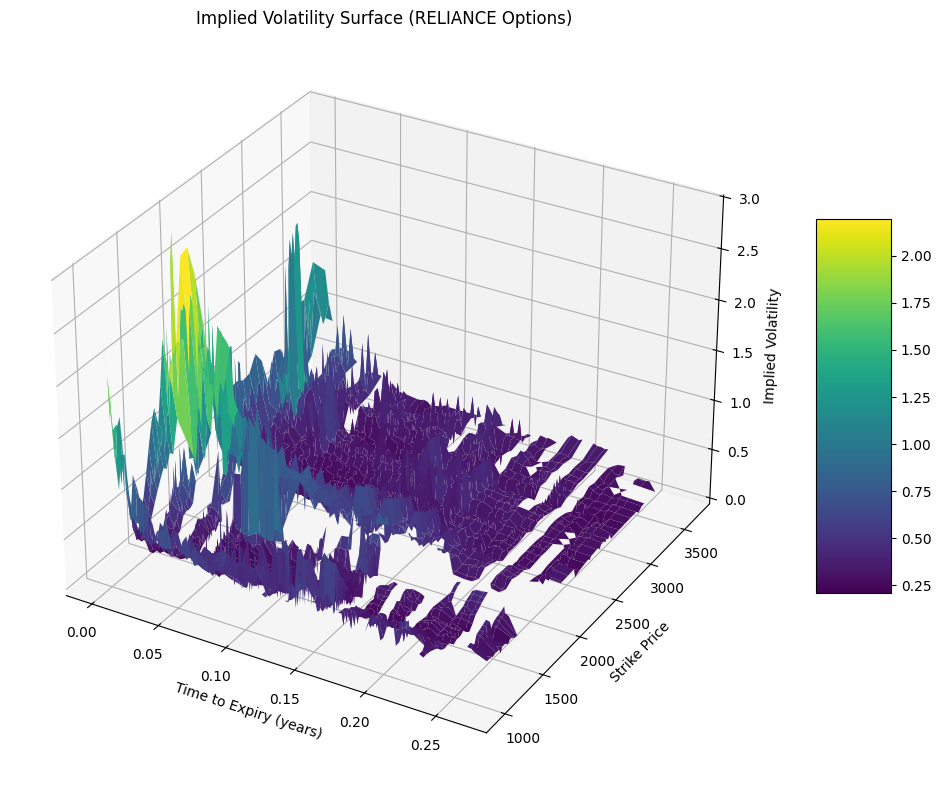

In [ ]:
# For visualization, filter to a single expiry or date if needed
import matplotlib.pyplot as plt

surface = options_data.pivot_table(index='Strike Price  ', columns='TimetoExpiry', values='ImpliedVol')

# Plot the surface
from mpl_toolkits.mplot3d import Axes3D

X, Y = np.meshgrid(surface.columns, surface.index)
Z = surface.values

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, Y, Z, cmap='viridis', linewidth=0, antialiased=True)
ax.set_xlabel('Time to Expiry (years)')
ax.set_ylabel('Strike Price')
ax.set_zlabel('Implied Volatility')
plt.title('Implied Volatility Surface (RELIANCE Options)')
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.tight_layout()
plt.show()


Might need to normalize data


In [ ]:
stock_data.rename(columns={'Close_RELIANCE.NS': 'Close'}, inplace=True)

In [ ]:
# Technical Indicators

stock_data['MA50'] = stock_data['Close'].rolling(50).mean()
stock_data['MA100'] = stock_data['Close'].rolling(100).mean()
stock_data['MA200'] = stock_data['Close'].rolling(200).mean()

def compute_rsi(series, period=14):
    delta = series.diff()
    gain = delta.where(delta > 0, 0).rolling(window=period).mean()
    loss = -delta.where(delta < 0, 0).rolling(window=period).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

stock_data['RSI'] = compute_rsi(stock_data['Close'], 14)

window = 20
# stock_data['BB_Middle'] = stock_data['Close'].rolling(window).mean()
# stock_data['BB_Std'] = stock_data['Close'].rolling(window).std()
# stock_data['BB_Upper'] = stock_data['BB_Middle'] + 2 * stock_data['BB_Std']
# stock_data['BB_Lower'] = stock_data['BB_Middle'] - 2 * stock_data['BB_Std']

ema12 = stock_data['Close'].ewm(span=12, adjust=False).mean()
ema26 = stock_data['Close'].ewm(span=26, adjust=False).mean()
stock_data['MACD'] = ema12 - ema26

In [ ]:
stock_data['MA_Signal'] = 0
stock_data['MA_Signal'] = np.where(
    (stock_data['MA50'] > stock_data['MA200']) & (stock_data['MA50'].shift(1) <= stock_data['MA200'].shift(1)),
    1,  # Buy
    np.where(
        (stock_data['MA50'] < stock_data['MA200']) & (stock_data['MA50'].shift(1) >= stock_data['MA200'].shift(1)),
        -1,  # Sell
        0  # Hold/No signal
    )
)


In [ ]:
stock_data['RSI_Signal'] = 0
stock_data['RSI_Signal'] = np.where(
    (stock_data['RSI'] > 30) & (stock_data['RSI'].shift(1) <= 30), 1,  # Buy
    np.where(
        (stock_data['RSI'] < 70) & (stock_data['RSI'].shift(1) >= 70), -1,  # Sell
        0
    )
)


In [ ]:
stock_data['MACD_Signal'] = 0
stock_data['MACD_Signal'] = np.where(
    (stock_data['MACD'] > stock_data['MACD'].ewm(span=9, adjust=False).mean()) &
    (stock_data['MACD'].shift(1) <= stock_data['MACD'].ewm(span=9, adjust=False).mean().shift(1)), 1,  # Buy
    np.where(
        (stock_data['MACD'] < stock_data['MACD'].ewm(span=9, adjust=False).mean()) &
        (stock_data['MACD'].shift(1) >= stock_data['MACD'].ewm(span=9, adjust=False).mean().shift(1)), -1,  # Sell
        0
    )
)


In [ ]:
# Helper Functions

def is_otm(row):
    # Out-of-the-money for call: S < K, for put: S > K
    if row['option_type_bsm'] == 'call':
        return row['Underlying Value'] < row['Strike Price']
    else:
        return row['Underlying Value'] > row['Strike Price']

def is_itm(row):
    # In-the-money for call: S > K, for put: S < K
    if row['option_type_bsm'] == 'call':
        return row['Underlying Value'] > row['Strike Price']
    else:
        return row['Underlying Value'] < row['Strike Price']

def kelly_fraction(win_rate, win_loss_ratio):
    """Calculate Kelly fraction."""
    return max(0, win_rate - (1 - win_rate) / win_loss_ratio)

def compute_kelly_fraction(returns, default_kelly=0.05, min_trades=10):
    returns = np.array(returns)
    if len(returns) < min_trades or (returns > 0).sum() == 0 or (returns < 0).sum() == 0:
        return default_kelly
    win_rate = (returns > 0).mean()
    avg_win = returns[returns > 0].mean()
    avg_loss = -returns[returns < 0].mean()  # Use positive value for loss
    if avg_loss == 0:
        return default_kelly
    b = avg_win / avg_loss
    kelly = (win_rate * b - (1 - win_rate)) / b if b != 0 else default_kelly
    return max(0, min(kelly, 1))


In [ ]:
display(stock_data[stock_data['RSI_Signal']==0])

,Date_,Open_RELIANCE.NS,High_RELIANCE.NS,Low_RELIANCE.NS,Close,Volume_RELIANCE.NS,Date,MA50,MA100,MA200,RSI,MACD,MA_Signal,RSI_Signal,MACD_Signal
0,2023-01-02,1172.682090,1186.018524,1171.854325,1184.592896,5316175,2023-01-02,NaN,NaN,NaN,NaN,0.000000,0,0,0
1,2023-01-03,1179.603215,1183.259245,1171.670422,1175.924194,7658932,2023-01-03,NaN,NaN,NaN,NaN,-0.691520,0,0,-1
2,2023-01-04,1175.901284,1177.763846,1156.126654,1158.219116,9264891,2023-01-04,NaN,NaN,NaN,NaN,-2.637800,0,0,0
3,2023-01-05,1160.495513,1166.427926,1151.527923,1156.149658,13637099,2023-01-05,NaN,NaN,NaN,NaN,-4.297688,0,0,0
4,2023-01-06,1161.944019,1171.739373,1158.104068,1166.657715,6349597,2023-01-06,NaN,NaN,NaN,NaN,-4.710943,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
576,2025-05-08,1404.099976,1420.800049,1398.000000,1407.000000,16106175,2025-05-08,1267.356997,1257.224498,1333.798126,86.567797,47.108860,0,0,0
577,2025-05-09,1385.500000,1394.800049,1374.500000,1377.199951,13668904,2025-05-09,1270.351997,1258.214498,1332.750750,72.934320,43.917291,0,0,0
578,2025-05-12,1400.000000,1439.000000,1400.000000,1436.500000,10674081,2025-05-12,1274.421997,1259.950498,1332.157500,76.887852,45.646780,0,0,0
579,2025-05-13,1433.500000,1447.699951,1412.400024,1415.699951,11407896,2025-05-13,1278.172996,1261.378998,1331.732625,72.335829,44.822338,0,0,0


In [ ]:
stock_data = stock_data.set_index(['Date'])

In [ ]:
# Strategy Implementation

options_data['Date'] = pd.to_datetime(options_data['Date'])
monthly_starts = options_data.groupby(options_data['Date'].dt.to_period('M')).first().reset_index(drop=True)

signals = []

for idx, row in monthly_starts.iterrows():
    date = row['Date']
    try:
        ma50_signal = stock_data.loc[date, 'MA_Signal_']
        macd_signal = stock_data.loc[date, 'MACD_Signal_']
    except KeyError:
        continue

    group = options_data[options_data['Date'] == date]
    position_size = capital * kelly_frac  # Dynamic position size

    # Bullish: Buy OTM Call, Short ITM Call
    if ma50_signal and macd_signal:
        otm_calls = group[(group['option_type_bsm'] == 'call') & group.apply(is_otm, axis=1)]
        itm_calls = group[(group['option_type_bsm'] == 'call') & group.apply(is_itm, axis=1)]
        if not otm_calls.empty and not itm_calls.empty:
            signals.append({
                'Date': date,
                'Action': 'Buy OTM Call',
                'Option': otm_calls.iloc[0].to_dict(),
                'PositionSize': position_size
            })
            signals.append({
                'Date': date,
                'Action': 'Short ITM Call',
                'Option': itm_calls.iloc[0].to_dict(),
                'PositionSize': position_size
            })

    # Bearish: Buy OTM Put, Short ITM Put
    elif not ma50_signal and not macd_signal:
        otm_puts = group[(group['option_type_bsm'] == 'put') & group.apply(is_otm, axis=1)]
        itm_puts = group[(group['option_type_bsm'] == 'put') & group.apply(is_itm, axis=1)]
        if not otm_puts.empty and not itm_puts.empty:
            signals.append({
                'Date': date,
                'Action': 'Buy OTM Put',
                # instead of iloc we can use rank or sort before selecting 1
                'Option': otm_puts.iloc[0].to_dict(),
                'PositionSize': position_size
            })
            signals.append({
                'Date': date,
                'Action': 'Short ITM Put',
                'Option': itm_puts.iloc[0].to_dict(),
                'PositionSize': position_size
            })

signals_df = pd.DataFrame(signals)
print(signals_df)

In [ ]:
display(options_data.columns)

Index(['Date', 'Symbol', 'Option type', 'Strike Price', 'Close',
       'Underlying Value', 'Expiry', 'TimetoExpiry', 'RiskFreeRate',
       'option_type_bsm', 'ImpliedVol'],
      dtype='object')

In [ ]:
stock_data.reset_index(inplace=True)

In [ ]:
display(stock_data)

,index,Open_RELIANCE.NS,High_RELIANCE.NS,Low_RELIANCE.NS,Close,Volume_RELIANCE.NS,MA50,MA100,MA200,RSI,MACD,MA_Signal,RSI_Signal,MACD_Signal,Date
Date_,,,,,,,,,,,,,,,
2023-01-02,0,1172.682090,1186.018524,1171.854325,1184.592896,5316175,NaN,NaN,NaN,NaN,0.000000,0,0,0,2023-01-02
2023-01-03,1,1179.603215,1183.259245,1171.670422,1175.924194,7658932,NaN,NaN,NaN,NaN,-0.691520,0,0,-1,2023-01-03
2023-01-04,2,1175.901284,1177.763846,1156.126654,1158.219116,9264891,NaN,NaN,NaN,NaN,-2.637800,0,0,0,2023-01-04
2023-01-05,3,1160.495513,1166.427926,1151.527923,1156.149658,13637099,NaN,NaN,NaN,NaN,-4.297688,0,0,0,2023-01-05
2023-01-06,4,1161.944019,1171.739373,1158.104068,1166.657715,6349597,NaN,NaN,NaN,NaN,-4.710943,0,0,0,2023-01-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-05-08,576,1404.099976,1420.800049,1398.000000,1407.000000,16106175,1267.356997,1257.224498,1333.798126,86.567797,47.108860,0,0,0,2025-05-08
2025-05-09,577,1385.500000,1394.800049,1374.500000,1377.199951,13668904,1270.351997,1258.214498,1332.750750,72.934320,43.917291,0,0,0,2025-05-09
2025-05-12,578,1400.000000,1439.000000,1400.000000,1436.500000,10674081,1274.421997,1259.950498,1332.157500,76.887852,45.646780,0,0,0,2025-05-12


In [ ]:
stock_data = stock_data.set_index('Date_')


In [ ]:
display(stock_data)

,index,Open_RELIANCE.NS,High_RELIANCE.NS,Low_RELIANCE.NS,Close,Volume_RELIANCE.NS,MA50,MA100,MA200,RSI,MACD,MA_Signal,RSI_Signal,MACD_Signal,Date
Date_,,,,,,,,,,,,,,,
2023-01-02,0,1172.682090,1186.018524,1171.854325,1184.592896,5316175,NaN,NaN,NaN,NaN,0.000000,0,0,0,2023-01-02
2023-01-03,1,1179.603215,1183.259245,1171.670422,1175.924194,7658932,NaN,NaN,NaN,NaN,-0.691520,0,0,-1,2023-01-03
2023-01-04,2,1175.901284,1177.763846,1156.126654,1158.219116,9264891,NaN,NaN,NaN,NaN,-2.637800,0,0,0,2023-01-04
2023-01-05,3,1160.495513,1166.427926,1151.527923,1156.149658,13637099,NaN,NaN,NaN,NaN,-4.297688,0,0,0,2023-01-05
2023-01-06,4,1161.944019,1171.739373,1158.104068,1166.657715,6349597,NaN,NaN,NaN,NaN,-4.710943,0,0,0,2023-01-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-05-08,576,1404.099976,1420.800049,1398.000000,1407.000000,16106175,1267.356997,1257.224498,1333.798126,86.567797,47.108860,0,0,0,2025-05-08
2025-05-09,577,1385.500000,1394.800049,1374.500000,1377.199951,13668904,1270.351997,1258.214498,1332.750750,72.934320,43.917291,0,0,0,2025-05-09
2025-05-12,578,1400.000000,1439.000000,1400.000000,1436.500000,10674081,1274.421997,1259.950498,1332.157500,76.887852,45.646780,0,0,0,2025-05-12


In [ ]:
# Strategy Implementation 2

stock_data['Date'] = pd.to_datetime(stock_data['Date'])
stock_data = stock_data.set_index('Date')

# --- Get first trading day of each month ---
options_data['Date'] = pd.to_datetime(options_data['Date'])
monthly_starts = options_data.groupby(options_data['Date'].dt.to_period('M')).first().reset_index(drop=True)

# --- Fixed position size for simplicity ---
capital = 100000
fixed_fraction =
position_size = capital * fixed_fraction

signals = []

for idx, row in monthly_starts.iterrows():
    date = row['Date']
    try:
        ma50_signal = stock_data.loc[date, 'MA_Signal']
        macd_signal = stock_data.loc[date, 'MACD_Signal']
    except KeyError:
        continue

    group = options_data[options_data['Date'] == date]
    avg_iv = group['ImpliedVol'].mean()

        # --- Only trade when average IV is less than the median (high volatility regime) ---
    if avg_iv > median_iv:
            continue

    # Bullish: Buy ITM Call, Sell OTM Call (Bull Call Spread)
    if ma50_signal and macd_signal:
        itm_calls = group[(group['option_type_bsm'] == 'call') & group.apply(is_itm, axis=1)]
        otm_calls = group[(group['option_type_bsm'] == 'call') & group.apply(is_otm, axis=1)]
        if not itm_calls.empty and not otm_calls.empty:
            # Buy lowest-strike ITM call, sell highest-strike OTM call
            buy_call = itm_calls.sort_values('Strike Price').iloc[0]
            sell_call = otm_calls.sort_values('Strike Price', ascending=False).iloc[0]
            signals.append({
                'Date': date,
                'Action': 'Buy ITM Call',
                'Option': buy_call.to_dict(),
                'PositionSize': position_size
            })
            signals.append({
                'Date': date,
                'Action': 'Short OTM Call',
                'Option': sell_call.to_dict(),
                'PositionSize': position_size
            })

    # Bearish: Buy ITM Put, Sell OTM Put (Bear Put Spread)
    elif not ma50_signal and not macd_signal:
        itm_puts = group[(group['option_type_bsm'] == 'put') & group.apply(is_itm, axis=1)]
        otm_puts = group[(group['option_type_bsm'] == 'put') & group.apply(is_otm, axis=1)]
        if not itm_puts.empty and not otm_puts.empty:
            # Buy highest-strike ITM put, sell lowest-strike OTM put
            buy_put = itm_puts.sort_values('Strike Price', ascending=False).iloc[0]
            sell_put = otm_puts.sort_values('Strike Price').iloc[0]
            signals.append({
                'Date': date,
                'Action': 'Buy ITM Put',
                'Option': buy_put.to_dict(),
                'PositionSize': position_size
            })
            signals.append({
                'Date': date,
                'Action': 'Short OTM Put',
                'Option': sell_put.to_dict(),
                'PositionSize': position_size
            })

signals_df = pd.DataFrame(signals)
display(signals_df)

,Date,Action,Option,PositionSize
0,2023-01-16,Buy ITM Put,"{'Date': 2023-01-16 00:00:00, 'Symbol': 'RELIA...",5000.0
1,2023-01-16,Short OTM Put,"{'Date': 2023-01-16 00:00:00, 'Symbol': 'RELIA...",5000.0
2,2023-02-01,Buy ITM Put,"{'Date': 2023-02-01 00:00:00, 'Symbol': 'RELIA...",5000.0
3,2023-02-01,Short OTM Put,"{'Date': 2023-02-01 00:00:00, 'Symbol': 'RELIA...",5000.0
4,2023-03-01,Buy ITM Put,"{'Date': 2023-03-01 00:00:00, 'Symbol': 'RELIA...",5000.0
5,2023-03-01,Short OTM Put,"{'Date': 2023-03-01 00:00:00, 'Symbol': 'RELIA...",5000.0
6,2023-04-17,Buy ITM Put,"{'Date': 2023-04-17 00:00:00, 'Symbol': 'RELIA...",5000.0
7,2023-04-17,Short OTM Put,"{'Date': 2023-04-17 00:00:00, 'Symbol': 'RELIA...",5000.0
8,2023-05-02,Buy ITM Put,"{'Date': 2023-05-02 00:00:00, 'Symbol': 'RELIA...",5000.0
9,2023-05-02,Short OTM Put,"{'Date': 2023-05-02 00:00:00, 'Symbol': 'RELIA...",5000.0


In [ ]:
display(signals_df)

,Date,Action,Option,PositionSize,PnL,KellyFraction
0,2023-01-16,Buy ITM Put,"{'Date': 2023-01-16 00:00:00, 'Symbol': 'RELIA...",0.0,NaN,0
1,2023-01-16,Short OTM Put,"{'Date': 2023-01-16 00:00:00, 'Symbol': 'RELIA...",0.0,NaN,0
2,2023-02-01,Buy ITM Put,"{'Date': 2023-02-01 00:00:00, 'Symbol': 'RELIA...",0.0,0.00,0
3,2023-02-01,Short OTM Put,"{'Date': 2023-02-01 00:00:00, 'Symbol': 'RELIA...",0.0,0.50,0
4,2023-03-01,Buy ITM Put,"{'Date': 2023-03-01 00:00:00, 'Symbol': 'RELIA...",0.0,-10.20,0
5,2023-03-01,Short OTM Put,"{'Date': 2023-03-01 00:00:00, 'Symbol': 'RELIA...",0.0,0.50,0
6,2023-04-17,Buy ITM Put,"{'Date': 2023-04-17 00:00:00, 'Symbol': 'RELIA...",0.0,NaN,0
7,2023-04-17,Short OTM Put,"{'Date': 2023-04-17 00:00:00, 'Symbol': 'RELIA...",0.0,NaN,0
8,2023-05-02,Buy ITM Put,"{'Date': 2023-05-02 00:00:00, 'Symbol': 'RELIA...",0.0,NaN,0
9,2023-05-02,Short OTM Put,"{'Date': 2023-05-02 00:00:00, 'Symbol': 'RELIA...",0.0,NaN,0


In [ ]:
import pandas as pd
import numpy as np

# --- Calculate median implied volatility across all options ---
median_iv = options_data['ImpliedVol'].median()

# capital = 100000
# returns = [0.1, -0.05, 0.2, -0.1, 0.05, 0.15]  # Example past returns

signals = []

for idx, row in monthly_starts.iterrows():
    date = row['Date']
    try:
        ma50_signal = stock_data.loc[date, 'MA_Signal']
        macd_signal = stock_data.loc[date, 'MACD_Signal']
    except KeyError:
        continue

    group = options_data[options_data['Date'] == date]
    avg_iv = group['ImpliedVol'].mean()
    position_size = capital * kelly_fraction
    # --- Only trade when average IV is less than the median (high volatility regime) ---
    if avg_iv > median_iv:
        continue

    # kelly_frac = compute_kelly_fraction(returns)
    # position_size = capital * kelly_frac

    # Bullish: Buy ITM Call, Sell OTM Call (Bull Call Spread)
    if ma50_signal and macd_signal:
        itm_calls = group[(group['option_type_bsm'] == 'call') & group.apply(is_itm, axis=1)]
        otm_calls = group[(group['option_type_bsm'] == 'call') & group.apply(is_otm, axis=1)]
        if not itm_calls.empty and not otm_calls.empty:
            buy_call = itm_calls.sort_values('Strike Price').iloc[0]
            sell_call = otm_calls.sort_values('Strike Price', ascending=False).iloc[0]
            signals.append({
                'Date': date,
                'Action': 'Buy ITM Call',
                'Option': buy_call.to_dict(),
                'PositionSize': position_size,
                'AvgIV': avg_iv
            })
            signals.append({
                'Date': date,
                'Action': 'Short OTM Call',
                'Option': sell_call.to_dict(),
                'PositionSize': position_size,
                'AvgIV': avg_iv
            })

    # Bearish: Buy ITM Put, Sell OTM Put (Bear Put Spread)
    elif not ma50_signal and not macd_signal:
        itm_puts = group[(group['option_type_bsm'] == 'put') & group.apply(is_itm, axis=1)]
        otm_puts = group[(group['option_type_bsm'] == 'put') & group.apply(is_otm, axis=1)]
        if not itm_puts.empty and not otm_puts.empty:
            buy_put = itm_puts.sort_values('Strike Price', ascending=False).iloc[0]
            sell_put = otm_puts.sort_values('Strike Price').iloc[0]
            signals.append({
                'Date': date,
                'Action': 'Buy ITM Put',
                'Option': buy_put.to_dict(),
                'PositionSize': position_size,
                'AvgIV': avg_iv
            })
            signals.append({
                'Date': date,
                'Action': 'Short OTM Put',
                'Option': sell_put.to_dict(),
                'PositionSize': position_size,
                'AvgIV': avg_iv
            })

signals_df = pd.DataFrame(signals)
display(signals_df)


,Date,Action,Option,PositionSize,AvgIV
0,2024-05-02,Buy ITM Put,"{'Date': 2024-05-02 00:00:00, 'Symbol': 'RELIA...",0.0,0.252368
1,2024-05-02,Short OTM Put,"{'Date': 2024-05-02 00:00:00, 'Symbol': 'RELIA...",0.0,0.252368
2,2024-08-01,Buy ITM Put,"{'Date': 2024-08-01 00:00:00, 'Symbol': 'RELIA...",0.0,0.268346
3,2024-08-01,Short OTM Put,"{'Date': 2024-08-01 00:00:00, 'Symbol': 'RELIA...",0.0,0.268346
4,2024-09-02,Buy ITM Put,"{'Date': 2024-09-02 00:00:00, 'Symbol': 'RELIA...",0.0,0.277518
5,2024-09-02,Short OTM Put,"{'Date': 2024-09-02 00:00:00, 'Symbol': 'RELIA...",0.0,0.277518
6,2024-12-02,Buy ITM Put,"{'Date': 2024-12-02 00:00:00, 'Symbol': 'RELIA...",0.0,0.270141
7,2024-12-02,Short OTM Put,"{'Date': 2024-12-02 00:00:00, 'Symbol': 'RELIA...",0.0,0.270141


In [ ]:
print(signals_df['Action'][0] )
print(signals_df['Option'][0])

Buy ITM Put
{'Date': Timestamp('2024-05-02 00:00:00'), 'Symbol': 'RELIANCE', 'Option type': 'PE', 'Strike Price': 3400.0, 'Close': 451.0, 'Underlying Value': 2933.1, 'Expiry': '2024-05-30', 'TimetoExpiry': 0.0767123287671232, 'RiskFreeRate': 0.0634, 'option_type_bsm': 'put', 'ImpliedVol': 0.2190716064197653}


In [ ]:
print(signals_df['Action'][1] )
print(signals_df['Option'][1])

Short OTM Put
{'Date': Timestamp('2024-05-02 00:00:00'), 'Symbol': 'RELIANCE', 'Option type': 'PE', 'Strike Price': 2480.0, 'Close': 1.1, 'Underlying Value': 2933.1, 'Expiry': '2024-05-30', 'TimetoExpiry': 0.0767123287671232, 'RiskFreeRate': 0.0634, 'option_type_bsm': 'put', 'ImpliedVol': 0.28591161205545906}


In [ ]:
import pandas as pd
import numpy as np

capital = 1_000_000
max_fraction = 0.05  # Maximum 5% of capital per trade
holding_period = 5   # e.g., 5 days

def get_exit_price(option_row, exit_date, options_data):
    mask = (
        (options_data['Date'] == exit_date) &
        (options_data['Symbol'] == option_row['Symbol']) &
        (options_data['Option type'] == option_row['Option type']) &
        (options_data['Strike Price'] == option_row['Strike Price']) &
        (options_data['Expiry'] == option_row['Expiry'])
    )
    result = options_data.loc[mask, 'Close']
    return result.values[0] if not result.empty else np.nan

pnls = []
kelly_fractions = []
position_sizes = []

for i, signal in signals_df.iterrows():
    entry_row = signal['Option']
    entry_date = pd.to_datetime(signal['Date'])
    exit_date = entry_date + pd.Timedelta(days=holding_period)
    entry_price = entry_row['Close']
    exit_price = get_exit_price(entry_row, exit_date, options_data)
    if np.isnan(exit_price):
        pnls.append(np.nan)
        kelly_fractions.append(0)
        position_sizes.append(0)
        continue

    # PnL calculation (pnl should be of both leg and should also include quantity)
    if 'Buy' in signal['Action']:
        pnl = exit_price - entry_price # pnl*quantity
    else:  # Short
        pnl = entry_price - exit_price # pnl*quantity (can be calculated from size or no. of contracts)
    pnls.append(pnl)

    # Kelly calculation based on history up to this trade
    win_pnls = [x for x in pnls if x is not None and x > 0]
    loss_pnls = [x for x in pnls if x is not None and x < 0]
    W = len(win_pnls) / len([x for x in pnls if x is not None]) if pnls else 0
    R = (np.mean(win_pnls) / abs(np.mean(loss_pnls))) if loss_pnls else 0
    kelly = W - (1-W)/R if R > 0 else 0
    kelly = max(0, kelly)
    kelly_fractions.append(kelly)

    # Dynamic position sizing
    position_size = kelly * max_fraction * capital
    position_sizes.append(position_size)

signals_df['PnL'] = pnls
signals_df['KellyFraction'] = kelly_fractions
signals_df['PositionSize'] = position_sizes


In [ ]:
# Kelly Criterion Position Sizing from signals_df with PnL column

wins = signals_df[signals_df['PnL'] > 0]['PnL']
losses = signals_df[signals_df['PnL'] < 0]['PnL']
W = len(wins) / len(signals_df) if len(signals_df) > 0 else 0
R = wins.mean() / abs(losses.mean()) if len(losses) > 0 else 0

kelly_fraction = W - (1 - W) / R if R != 0 else 0
kelly_fraction = max(0, kelly_fraction)

capital = 1000000
max_fraction = 0.05
position_size = kelly_fraction * max_fraction * capital

signals_df['PositionSize'] = position_size

print(f"Kelly fraction: {kelly_fraction:.2%}")
print(f"Recommended position size: ₹{position_size:,.0f}")


Kelly fraction: 11.13%
Recommended position size: ₹5,567


In [ ]:
# Performance Metrics

import numpy as np
import pandas as pd

df = signals_df[signals_df['PositionSize'] > int(-777) ].copy()

df['Return'] = df['PnL'] / df['PositionSize']

# Build equity curve
initial_capital = 1_000_000
df['Equity'] = initial_capital + df['PnL'].cumsum()

# Annualization factor: estimate trades/year from your data
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')
years = (df['Date'].iloc[-1] - df['Date'].iloc[0]).days / 365.25
trades_per_year = len(df) / years if years > 0 else 1

# Sharpe Ratio (annualized)
risk_free_rate = 0.05
rf_per_trade = risk_free_rate / trades_per_year
excess_returns = df['Return'] - rf_per_trade
sharpe = excess_returns.mean() / excess_returns.std() if excess_returns.std() > 0 else 0
sharpe_annual = sharpe * np.sqrt(trades_per_year)

# Sortino Ratio (annualized)
downside = excess_returns[excess_returns < 0]
sortino = excess_returns.mean() / downside.std() if downside.std() > 0 else 0
sortino_annual = sortino * np.sqrt(trades_per_year)

# Calmar Ratio
df['CumulativeReturn'] = (1 + df['Return']).cumprod()
df['CumulativeMax'] = df['CumulativeReturn'].cummax()
df['Drawdown'] = (df['CumulativeReturn'] - df['CumulativeMax']) / df['CumulativeMax']
max_drawdown = df['Drawdown'].min()
annual_return = df['CumulativeReturn'].iloc[-1] ** (trades_per_year / len(df)) - 1 if len(df) > 0 else 0
calmar = annual_return / abs(max_drawdown) if max_drawdown != 0 else np.nan

# Recovery Factor
total_net_profit = df['PnL'].sum()
recovery_factor = total_net_profit / abs(max_drawdown * initial_capital) if max_drawdown != 0 else np.nan

# Value at Risk (VaR 95%)
var_95 = np.percentile(df['Return'], 5)

# Output
print(f"Annualized Sharpe Ratio: {sharpe_annual:.2f}")
print(f"Annualized Sortino Ratio: {sortino_annual:.2f}")
print(f"Calmar Ratio: {calmar:.2f}")
print(f"Maximum Drawdown: {max_drawdown:.2%}")
print(f"Recovery Factor: {recovery_factor:.2f}")
print(f"Value at Risk (VaR 95%): {var_95:.2%}")


Annualized Sharpe Ratio: 0.19
Annualized Sortino Ratio: 8.79
Calmar Ratio: nan
Maximum Drawdown: -0.05%
Recovery Factor: 0.17
Value at Risk (VaR 95%): nan%


In [ ]:
# Backtesting Framework

import numpy as np
import pandas as pd

class OptionsBacktester:
    def __init__(self, signals_df, options_data, execution_delay=1, slippage_bps=10, impact_bps=5):
        self.signals_df = signals_df
        self.options_data = options_data
        self.execution_delay = execution_delay  # in days
        self.slippage_bps = slippage_bps      # basis points (0.01% per bp)
        self.impact_bps = impact_bps          # market impact in bps
        self.exceptions = []
        self.results = []

    def get_execution_price(self, option_row, exec_date, action):
        mask = (
            (self.options_data['Date'] == exec_date) &
            (self.options_data['Symbol'] == option_row['Symbol']) &
            (self.options_data['Option type'] == option_row['Option type']) &
            (self.options_data['Strike Price'] == option_row['Strike Price']) &
            (self.options_data['Expiry'] == option_row['Expiry'])
        )
        price_series = self.options_data.loc[mask, 'Close']
        if price_series.empty or np.isnan(price_series.values[0]):
            self.exceptions.append({'type': 'InvalidPrice', 'date': exec_date, 'option': option_row})
            return np.nan
        price = price_series.values[0]
        # Apply slippage and market impact
        adj = 1 + ((self.slippage_bps + self.impact_bps) / 10000)
        if 'Buy' in action:
            return price * adj
        else:
            return price / adj

    def run(self, holding_period=5):
        for i, signal in self.signals_df.iterrows():
            entry_row = signal['Option']
            entry_date = pd.to_datetime(signal['Date']) + pd.Timedelta(days=self.execution_delay)
            exit_date = entry_date + pd.Timedelta(days=holding_period)
            action = signal['Action']
            entry_price = self.get_execution_price(entry_row, entry_date, action)
            exit_price = self.get_execution_price(entry_row, exit_date, action)
            if np.isnan(entry_price) or np.isnan(exit_price):
                self.results.append({'PnL': np.nan, 'EntryDate': entry_date, 'ExitDate': exit_date, 'Exception': True})
                continue
            # PnL calculation
            pnl = (exit_price - entry_price) if 'Buy' in action else (entry_price - exit_price)
            self.results.append({'PnL': pnl, 'EntryDate': entry_date, 'ExitDate': exit_date, 'Exception': False})
        return pd.DataFrame(self.results)

    def exception_report(self):
        return pd.DataFrame(self.exceptions)


In [ ]:
def monte_carlo_simulation(signals_df, options_data, n_simulations=100, volatility_multipliers=[0.8, 1.0, 1.2, 1.5], shock_prob=0.05, shock_magnitude=0.2):
    all_results = []
    for sim in range(n_simulations):
        # Randomly pick a volatility regime
        vol_multiplier = np.random.choice(volatility_multipliers)
        # Copy data and apply volatility regime
        sim_data = options_data.copy()
        # Simulate market shocks
        shock_days = sim_data.sample(frac=shock_prob).index
        sim_data.loc[shock_days, 'Close'] *= (1 - np.random.choice([shock_magnitude, -shock_magnitude], size=len(shock_days)))
        # Apply volatility regime
        sim_data['Close'] = sim_data['Close'] * (1 + np.random.normal(0, (sim_data['ImpliedVol'] * vol_multiplier) / 10, size=len(sim_data)))
        # Run backtest
        backtester = OptionsBacktester(signals_df, sim_data)
        result = backtester.run()
        result['Simulation'] = sim
        all_results.append(result)
    return pd.concat(all_results, ignore_index=True)


In [ ]:
def analyze_exceptions(backtester):
    exceptions = backtester.exception_report()
    print(f"Total exceptions: {len(exceptions)}")
    print(exceptions['type'].value_counts())
    return exceptions


In [ ]:
# Run the base backtest
backtester = OptionsBacktester(signals_df, options_data)
results = backtester.run()
print("Base backtest results summary:")
print(results.describe())
exceptions = analyze_exceptions(backtester)

# Monte Carlo simulation
mc_results = monte_carlo_simulation(signals_df, options_data)
print("Monte Carlo simulation results summary:")
print(mc_results.groupby('Simulation')['PnL'].sum().describe())


Base backtest results summary:
             PnL            EntryDate             ExitDate
count   4.000000                    8                    8
mean    4.957875  2024-08-18 00:00:00  2024-08-23 00:00:00
min    -0.299551  2024-05-03 00:00:00  2024-05-08 00:00:00
25%    -0.299551  2024-07-10 06:00:00  2024-07-15 06:00:00
50%    -0.149775  2024-08-18 00:00:00  2024-08-23 00:00:00
75%     5.107650  2024-09-25 18:00:00  2024-09-30 18:00:00
max    20.430600  2024-12-03 00:00:00  2024-12-08 00:00:00
std    10.316117                  NaN                  NaN
Total exceptions: 4
type
InvalidPrice    4
Name: count, dtype: int64
Monte Carlo simulation results summary:
count    100.000000
mean      -0.574728
std        0.139575
min       -0.950025
25%       -0.650095
50%       -0.584698
75%       -0.516608
max       -0.181965
Name: PnL, dtype: float64


In [ ]:
def compute_volatility(series, window=20):
    """Compute rolling volatility (standard deviation) as a proxy for risk."""
    return series.rolling(window=window).std()

def stop_loss_trigger(entry_price, current_price, underlying_vol, k=2):
    """Stop-loss: Exit if loss exceeds k * volatility units."""
    threshold = entry_price - k * underlying_vol
    return current_price <= threshold

def trailing_stop_trigger(max_price, current_price, underlying_vol, k=1):
    """Trailing stop: Exit if current price falls by k * volatility units from max."""
    threshold = max_price - k * underlying_vol
    return current_price <= threshold


In [ ]:
def position_size_call(capital, risk_per_trade, underlying_vol, price):
    """
    Position sizing: Allocate less capital to more volatile assets.
    risk_per_trade: fraction of capital to risk per trade (e.g., 0.01 for 1%)
    underlying_vol: volatility of underlying asset (e.g., daily std dev)
    price: entry price of the option
    """
    # Risk per contract = underlying_vol * contract_multiplier
    # For simplicity, assume contract_multiplier = 1
    size = (capital * risk_per_trade) / (underlying_vol * price)
    return max(1, int(size))  # At least 1 contract


In [ ]:
def portfolio_risk_check(current_risk, max_portfolio_risk):
    """
    Prevent new trades if portfolio risk exceeds threshold.
    current_risk: sum of risk on all open positions
    max_portfolio_risk: e.g., 0.10 for 10% of capital
    """
    return current_risk < max_portfolio_risk


In [ ]:
def stress_test(options_data, shock_pct=-0.2):
    """
    Simulate a market shock (e.g., -20% drop) and revalue all options.
    Returns the new options_data with shocked prices.
    """
    shocked_data = options_data.copy()
    shocked_data['Underlying Value'] *= (1 + shock_pct)
    # Recalculate option prices if you have a pricing model, or just scale Close
    shocked_data['Close'] *= (1 + shock_pct)
    return shocked_data


In [ ]:
# Risk Management


portfolio_risk = 0
max_portfolio_risk = 0.10  # 10% of capital
risk_per_trade = 0.01      # 1% of capital per trade

results = []
for i, signal in signals_df.iterrows():
    entry_row = signal['Option']
    entry_date = pd.to_datetime(signal['Date'])
    underlying = entry_row['Underlying Value']
    # Compute volatility of underlying (use past 20 days)
    past_prices = stock_data.loc[:entry_date]['Close'].tail(20)
    if len(past_prices) < 20:
        continue
    underlying_vol = compute_volatility(past_prices).iloc[-1]
    entry_price = entry_row['Close']
    size = position_size(capital, risk_per_trade, underlying_vol, entry_price)
    # Portfolio risk check
    if not portfolio_risk_check(portfolio_risk, max_portfolio_risk):
        continue  # Skip trade if portfolio risk is too high

    max_price = entry_price
    exit_price = entry_price
    for day in range(1, 11):  # max 10-day hold
        try:
            current_date = entry_date + pd.Timedelta(days=day)
            current_row = options_data[
                (options_data['Date'] == current_date) &
                (options_data['Symbol'] == entry_row['Symbol']) &
                (options_data['Option type'] == entry_row['Option type']) &
                (options_data['Strike Price'] == entry_row['Strike Price']) &
                (options_data['Expiry'] == entry_row['Expiry'])
            ]
            if current_row.empty:
                break
            current_price = current_row['Close'].values[0]
            max_price = max(max_price, current_price)
            # Check stop-loss
            if stop_loss_trigger(entry_price, current_price, underlying_vol):
                exit_price = current_price
                break
            # Check trailing stop
            if trailing_stop_trigger(max_price, current_price, underlying_vol):
                exit_price = current_price
                break
            exit_price = current_price  # update for last day
        except Exception as e:
            break
    pnl = (exit_price - entry_price) * size if 'Buy' in signal['Action'] else (entry_price - exit_price) * size
    results.append({'EntryDate': entry_date, 'ExitDate': current_date, 'PnL': pnl, 'Size': size})
    # Update portfolio risk (simple sum of per-trade risk)
    portfolio_risk += risk_per_trade


In [ ]:
shocked_options = stress_test(options_data, shock_pct=-0.3)  # 30% market drop


In [ ]:
display(shocked_options)

,Date,Symbol,Option type,Strike Price,Close,Underlying Value,Expiry,TimetoExpiry,RiskFreeRate,option_type_bsm,ImpliedVol,Return,CumulativeReturn,MarketRegime
0,2024-10-14,RELIANCE,CE,2320.0,319.200,1921.535,2024-10-31,0.046575,0.0634,call,0.697366,0.000000,1.000000,NaN
1,2024-10-14,RELIANCE,CE,2360.0,473.165,1921.535,2024-10-31,0.046575,0.0634,call,2.086734,0.482346,1.482346,NaN
2,2024-10-14,RELIANCE,CE,2400.0,447.055,1921.535,2024-10-31,0.046575,0.0634,call,2.009741,-0.055182,1.400548,NaN
3,2024-10-14,RELIANCE,CE,2440.0,421.260,1921.535,2024-10-31,0.046575,0.0634,call,1.934938,-0.057700,1.319737,NaN
4,2024-10-14,RELIANCE,CE,2480.0,395.920,1921.535,2024-10-31,0.046575,0.0634,call,1.863020,-0.060153,1.240351,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148565,2023-04-13,RELIANCE,CE,2600.0,26.565,1810.795,2023-06-29,0.210959,0.0634,call,0.054780,-0.084439,0.083224,Bear
148566,2023-04-13,RELIANCE,CE,2620.0,24.325,1810.795,2023-06-29,0.210959,0.0634,call,0.071575,-0.084321,0.076206,Bear
148567,2023-04-13,RELIANCE,CE,2640.0,22.225,1810.795,2023-06-29,0.210959,0.0634,call,0.084398,-0.086331,0.069627,Bear
148568,2023-04-13,RELIANCE,CE,2660.0,20.300,1810.795,2023-06-29,0.210959,0.0634,call,0.095142,-0.086614,0.063596,Bear


In [ ]:
results_df = pd.DataFrame(results)
display(results_df)

,EntryDate,ExitDate,PnL,Size
0,2024-05-02,2024-05-04,148.3,2
1,2024-05-02,2024-05-04,-93.2,932
2,2024-08-01,2024-08-03,0.0,1
3,2024-08-01,2024-08-03,-24.9,249
4,2024-09-02,2024-09-07,0.0,1
5,2024-09-02,2024-09-07,29.3,293
6,2024-12-02,2024-12-05,-40.0,1
7,2024-12-02,2024-12-07,162.0,648


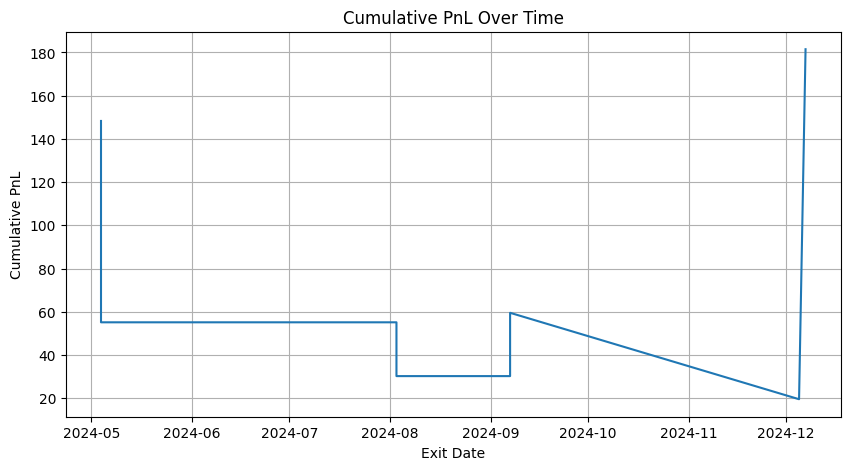

In [ ]:
# Visualization and Reporting

import matplotlib.pyplot as plt

results_df['CumulativePnL'] = results_df['PnL'].cumsum()
plt.figure(figsize=(10, 5))
plt.plot(results_df['ExitDate'], results_df['CumulativePnL'])
plt.title('Cumulative PnL Over Time')
plt.xlabel('Exit Date')
plt.ylabel('Cumulative PnL')
plt.grid()
plt.show()


In [ ]:
# Example: Recalculate PnL on shocked data for open positions
shocked_pnls = []
for i, signal in signals_df.iterrows():
    entry_row = signal['Option']
    shocked_row = shocked_options[
        (shocked_options['Date'] == entry_row['Date']) &
        (shocked_options['Symbol'] == entry_row['Symbol']) &
        (shocked_options['Option type'] == entry_row['Option type']) &
        (shocked_options['Strike Price'] == entry_row['Strike Price']) &
        (shocked_options['Expiry'] == entry_row['Expiry'])
    ]
    if shocked_row.empty:
        shocked_pnls.append(None)
        continue
    shocked_price = shocked_row['Close'].values[0]
    entry_price = entry_row['Close']
    shocked_pnl = shocked_price - entry_price if 'Buy' in signal['Action'] else entry_price - shocked_price
    shocked_pnls.append(shocked_pnl)

print("\nStress Test PnLs (first 10):")
print(shocked_pnls[:10])
print(f"Average PnL under stress: {np.nanmean(shocked_pnls):.2f}")



Stress Test PnLs (first 10):
[np.float64(-135.3), np.float64(0.33000000000000007), np.float64(-174.0), np.float64(0.28500000000000003), np.float64(-136.03500000000003), np.float64(0.43500000000000005), np.float64(-63.0), np.float64(0.16500000000000004)]
Average PnL under stress: -63.39


In [ ]:
commission = 0.001  # 0.1% per trade
slippage = 0.0005   # 0.05% per trade

df['TotalCost'] = (commission + slippage) * df['PositionSize']
df['PnL_net'] = df['PnL'] - df['TotalCost']
df['Return_net'] = df['PnL_net'] / df['PositionSize']


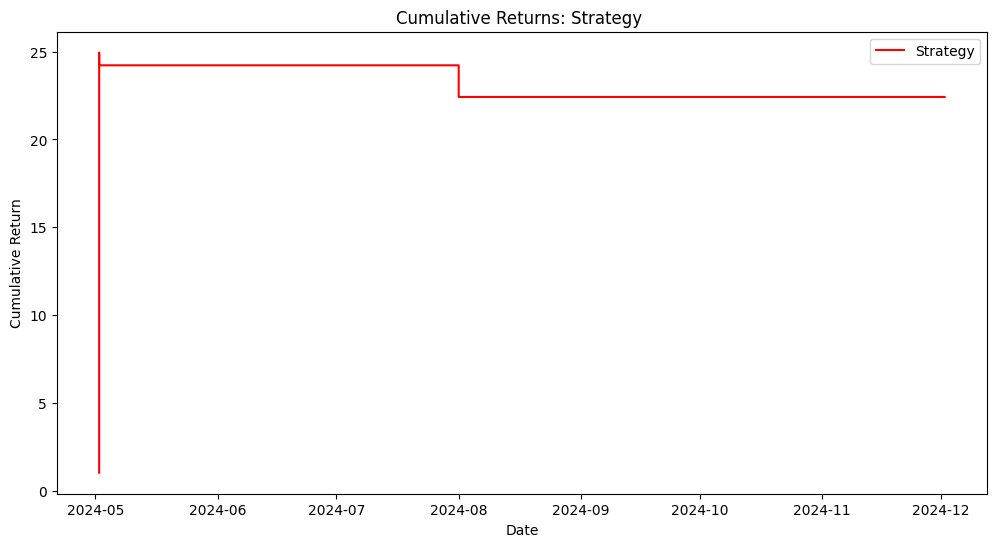

In [ ]:
import matplotlib.pyplot as plt

# Assume df contains: Date, Return (your strategy), and benchmark_df contains: Date, Return (e.g., Nifty 50)
benchmark_df = options_data
benchmark_df['Return'] = benchmark_df['Close'].pct_change().fillna(0)
df['Return'] = df['Return'].fillna(0)
df['CumulativeReturn'] = (1 + df['Return']).cumprod()
benchmark_df['CumulativeReturn'] = (1 + benchmark_df['Return']).cumprod()

# strategy is a straight line at 1
plt.close('all')
plt.figure(figsize=(12,6))
plt.plot(df['Date'], df['CumulativeReturn'], label='Strategy', color ='red')
# plt.plot(benchmark_df['Date'], benchmark_df['CumulativeReturn'], label='Nifty 50', alpha=0.7, color = 'blue')
plt.title('Cumulative Returns: Strategy ')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.show()


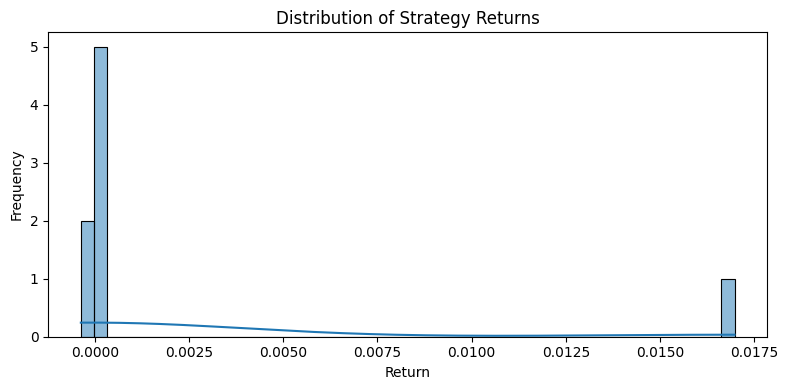

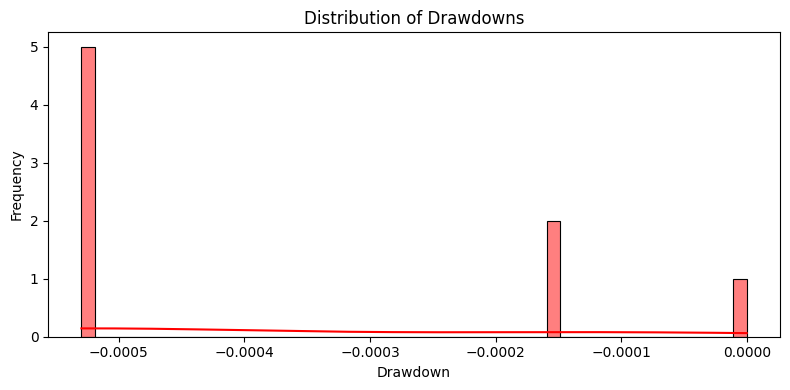

In [ ]:
import seaborn as sns

# Distribution of returns
plt.figure(figsize=(8,4))
sns.histplot(df['Return'], bins=50, kde=True)
plt.title('Distribution of Strategy Returns')
plt.xlabel('Return')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# Drawdown calculation and distribution
df['CumulativeMax'] = df['CumulativeReturn'].cummax()
df['Drawdown'] = (df['CumulativeReturn'] - df['CumulativeMax']) / df['CumulativeMax']

plt.figure(figsize=(8,4))
sns.histplot(df['Drawdown'], bins=50, kde=True, color='red')
plt.title('Distribution of Drawdowns')
plt.xlabel('Drawdown')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()


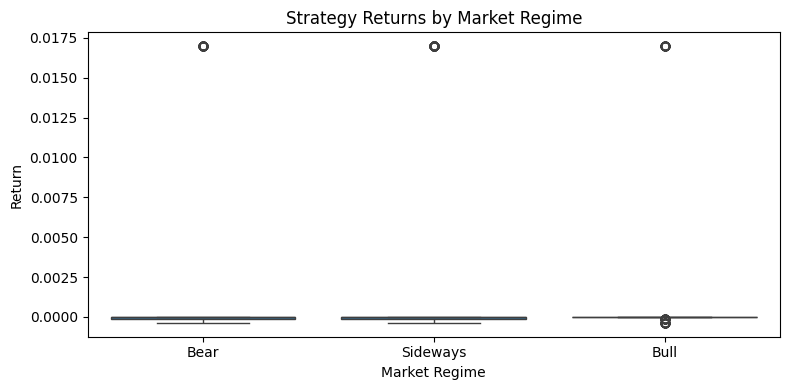

In [ ]:
# Simple regime classifier: rolling benchmark return
benchmark_df['MarketRegime'] = pd.qcut(benchmark_df['Return'].rolling(20).mean(),
                                       q=[0, 0.33, 0.66, 1],
                                       labels=['Bear', 'Sideways', 'Bull'])

# Merge regime info back to strategy df
df = df.merge(benchmark_df[['Date', 'MarketRegime']], on='Date', how='left')

# Boxplot of returns by regime
plt.figure(figsize=(8,4))
sns.boxplot(x='MarketRegime', y='Return', data=df)
plt.title('Strategy Returns by Market Regime')
plt.xlabel('Market Regime')
plt.ylabel('Return')
plt.tight_layout()
plt.show()


In [ ]:
class VaRCalculator:
    def __init__(self, returns):
        self.returns = np.array(returns.dropna())

    def parametric_var(self, alpha=0.05):
        mean = np.mean(self.returns)
        std = np.std(self.returns)
        var = mean + std * np.percentile(self.returns, alpha*100)
        return var

    def historical_var(self, alpha=0.05):
        return np.percentile(self.returns, 100*alpha)

# Usage
var_calc = VaRCalculator(df['Return'])
parametric_var = var_calc.parametric_var(0.05)
historical_var = var_calc.historical_var(0.05)
print(f"Parametric VaR (95%): {parametric_var:.4f}")
print(f"Historical VaR (95%): {historical_var:.4f}")


Parametric VaR (95%): 0.0020
Historical VaR (95%): -0.0004


In [ ]:
print(signals_df['PnL'].sum())

91.59999999999997


In [ ]:
import pandas as pd
import numpy as np

# --- PARAMETERS ---
capital = 100000
risk_per_trade = 0.01
max_portfolio_risk = 0.10
position_size1 = capital * risk_per_trade

# --- Calculate median implied volatility across all options ---
median_iv = options_data['ImpliedVol'].median()

signals = []

for idx, row in monthly_starts.iterrows():
    date = row['Date']
    try:
        ma50_signal = stock_data.loc[date, 'MA_Signal']
        macd_signal = stock_data.loc[date, 'MACD_Signal']
    except KeyError:
        continue

    group = options_data[options_data['Date'] == date]
    avg_iv = group['ImpliedVol'].mean()

    # --- Only trade when average IV is BELOW the median (low volatility regime) ---
    if avg_iv > median_iv:
        continue  # Skip this month if volatility is high

    # Bullish: Buy ITM Call, Sell OTM Call (Bull Call Spread)
    if ma50_signal and macd_signal:
        itm_calls = group[(group['option_type_bsm'] == 'call') & group.apply(is_itm, axis=1)]
        otm_calls = group[(group['option_type_bsm'] == 'call') & group.apply(is_otm, axis=1)]
        if not itm_calls.empty and not otm_calls.empty:
            buy_call = itm_calls.sort_values('Strike Price').iloc[0]
            sell_call = otm_calls.sort_values('Strike Price', ascending=False).iloc[0]
            signals.append({
                'Date': date,
                'Action': 'Buy ITM Call',
                'Option': buy_call.to_dict(),
                'PositionSize': position_size,
                'AvgIV': avg_iv
            })
            signals.append({
                'Date': date,
                'Action': 'Short OTM Call',
                'Option': sell_call.to_dict(),
                'PositionSize': position_size,
                'AvgIV': avg_iv
            })

    # Bearish: Buy ITM Put, Sell OTM Put (Bear Put Spread)
    elif not ma50_signal and not macd_signal:
        itm_puts = group[(group['option_type_bsm'] == 'put') & group.apply(is_itm, axis=1)]
        otm_puts = group[(group['option_type_bsm'] == 'put') & group.apply(is_otm, axis=1)]
        if not itm_puts.empty and not otm_puts.empty:
            buy_put = itm_puts.sort_values('Strike Price', ascending=False).iloc[0]
            sell_put = otm_puts.sort_values('Strike Price').iloc[0]
            signals.append({
                'Date': date,
                'Action': 'Buy ITM Put',
                'Option': buy_put.to_dict(),
                'PositionSize': position_size,
                'AvgIV': avg_iv
            })
            signals.append({
                'Date': date,
                'Action': 'Short OTM Put',
                'Option': sell_put.to_dict(),
                'PositionSize': position_size,
                'AvgIV': avg_iv
            })

signals_df = pd.DataFrame(signals)
display(signals_df)

# ---- BACKTEST THE SPREADS (with risk management) ----

results = []
portfolio_risk = 0

i = 0
while i < len(signals_df):
    if i+1 >= len(signals_df):
        break
    signal1 = signals_df.iloc[i]
    signal2 = signals_df.iloc[i+1]
    if signal1['Date'] != signal2['Date']:
        i += 1
        continue

    buy_leg = signal1 if 'Buy' in signal1['Action'] else signal2
    sell_leg = signal2 if 'Short' in signal2['Action'] else signal1

    entry_date = pd.to_datetime(buy_leg['Date'])
    past_prices = stock_data.loc[:entry_date]['Close'].tail(20)
    if len(past_prices) < 20:
        i += 2
        continue

    underlying_vol = compute_volatility(past_prices).iloc[-1]
    buy_entry_price = buy_leg['Option']['Close']
    sell_entry_price = sell_leg['Option']['Close']
    spread_entry = buy_entry_price - sell_entry_price

    size = position_size_call(capital, risk_per_trade, underlying_vol, spread_entry)
    if not portfolio_risk_check(portfolio_risk, max_portfolio_risk):
        i += 2
        continue

    max_spread_price = spread_entry
    exit_spread_price = spread_entry
    for day in range(1, 11):
        try:
            current_date = entry_date + pd.Timedelta(days=day)
            buy_leg_row = options_data[
                (options_data['Date'] == current_date) &
                (options_data['Symbol'] == buy_leg['Option']['Symbol']) &
                (options_data['Option type'] == buy_leg['Option']['Option type']) &
                (options_data['Strike Price'] == buy_leg['Option']['Strike Price']) &
                (options_data['Expiry'] == buy_leg['Option']['Expiry'])
            ]
            sell_leg_row = options_data[
                (options_data['Date'] == current_date) &
                (options_data['Symbol'] == sell_leg['Option']['Symbol']) &
                (options_data['Option type'] == sell_leg['Option']['Option type']) &
                (options_data['Strike Price'] == sell_leg['Option']['Strike Price']) &
                (options_data['Expiry'] == sell_leg['Option']['Expiry'])
            ]
            if buy_leg_row.empty or sell_leg_row.empty:
                break
            buy_price = buy_leg_row['Close'].values[0]
            sell_price = sell_leg_row['Close'].values[0]
            spread_price = buy_price - sell_price
            max_spread_price = max(max_spread_price, spread_price)
            if stop_loss_trigger(spread_entry, spread_price, underlying_vol):
                exit_spread_price = spread_price
                break
            if trailing_stop_trigger(max_spread_price, spread_price, underlying_vol):
                exit_spread_price = spread_price
                break
            exit_spread_price = spread_price
        except Exception as e:
            break

    pnl = (exit_spread_price - spread_entry) * size
    results.append({
        'EntryDate': entry_date,
        'ExitDate': current_date,
        'PnL': pnl,
        'Size': size,
        'SpreadType': 'Bull Call' if 'Call' in buy_leg['Action'] else 'Bear Put'
    })
    portfolio_risk += risk_per_trade
    i += 2

results_df = pd.DataFrame(results)
print(results_df.head())
print(results_df.describe())


,Date,Action,Option,PositionSize,AvgIV
0,2024-05-02,Buy ITM Put,"{'Date': 2024-05-02 00:00:00, 'Symbol': 'RELIA...",1000.0,0.252368
1,2024-05-02,Short OTM Put,"{'Date': 2024-05-02 00:00:00, 'Symbol': 'RELIA...",1000.0,0.252368
2,2024-08-01,Buy ITM Put,"{'Date': 2024-08-01 00:00:00, 'Symbol': 'RELIA...",1000.0,0.268346
3,2024-08-01,Short OTM Put,"{'Date': 2024-08-01 00:00:00, 'Symbol': 'RELIA...",1000.0,0.268346
4,2024-09-02,Buy ITM Put,"{'Date': 2024-09-02 00:00:00, 'Symbol': 'RELIA...",1000.0,0.277518
5,2024-09-02,Short OTM Put,"{'Date': 2024-09-02 00:00:00, 'Symbol': 'RELIA...",1000.0,0.277518
6,2024-12-02,Buy ITM Put,"{'Date': 2024-12-02 00:00:00, 'Symbol': 'RELIA...",1000.0,0.270141
7,2024-12-02,Short OTM Put,"{'Date': 2024-12-02 00:00:00, 'Symbol': 'RELIA...",1000.0,0.270141


   EntryDate   ExitDate    PnL  Size SpreadType
0 2024-05-02 2024-05-04  74.05     1   Bear Put
1 2024-08-01 2024-08-03  -0.10     1   Bear Put
2 2024-09-02 2024-09-07   0.10     1   Bear Put
3 2024-12-02 2024-12-05 -39.80     1   Bear Put
                 EntryDate             ExitDate           PnL  Size
count                    4                    4  4.000000e+00   4.0
mean   2024-08-17 00:00:00  2024-08-20 00:00:00  8.562500e+00   1.0
min    2024-05-02 00:00:00  2024-05-04 00:00:00 -3.980000e+01   1.0
25%    2024-07-09 06:00:00  2024-07-11 06:00:00 -1.002500e+01   1.0
50%    2024-08-17 00:00:00  2024-08-20 12:00:00  2.842171e-14   1.0
75%    2024-09-24 18:00:00  2024-09-29 06:00:00  1.858750e+01   1.0
max    2024-12-02 00:00:00  2024-12-05 00:00:00  7.405000e+01   1.0
std                    NaN                  NaN  4.751911e+01   0.0


In [ ]:
print(results_df['PnL'].describe())

count    4.000000e+00
mean     8.562500e+00
std      4.751911e+01
min     -3.980000e+01
25%     -1.002500e+01
50%      2.842171e-14
75%      1.858750e+01
max      7.405000e+01
Name: PnL, dtype: float64


In [ ]:
'''
Reasons for bad performance
1. Dataset has short Time to Expiry
2. Dataset has less entries
3. Signals are not good
AI Tools used
1. Chatgpt
2. Perplexity

Dataset taken from nseindia
After installing csv for jan2023-may-2025
1. Merged csv and removed duplicate rows if any
2. Dropped columns that were not used
3. Calculated risk free rate
4. Calculate time to expiry by subtracted expiry date from date
'''

In [ ]:
%%shell jupyter nbconvert --to html /content/drive/MyDrive/Colab\ Notebooks/Assignment.ipynb

UsageError: unrecognized arguments: jupyter nbconvert --to html /content/drive/MyDrive/Colab\ Notebooks/Assignment.ipynb


In [ ]:
!jupyter nbconvert --to html /content/drive/MyDrive/Colab\ Notebooks/Assignment.ipynb


[NbConvertApp] Converting notebook /content/drive/MyDrive/Colab Notebooks/Assignment.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 6 image(s).
[NbConvertApp] Writing 1158697 bytes to /content/drive/MyDrive/Colab Notebooks/Assignment.html


In [ ]:
from google.colab import drive
import os, glob

notebook_name = 'Assignment.ipynb'  # Replace with your notebook's name

drive.mount('/content/drive')

notebook_path = glob.glob(f'/content/drive/**/*.ipynb', recursive=True)
notebook_path = [path for path in notebook_path if notebook_name in path]

if notebook_path:
    print(notebook_path[0])
else:
    print("Notebook not found.")

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/Assignment.ipynb
